https://doheon.github.io/%EC%BD%94%EB%93%9C%EA%B5%AC%ED%98%84/time-series/ci-4.transformer-post/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('Data/서울_data.csv')
df = data.loc[:, ['date', 'daily_Acc']]
df.rename(columns = {'daily_Acc':'AC', 'date':'Date'}, inplace = True)
df['DAC'] = df['AC'] - df['AC'].shift(1)
df['DDAC'] = df['DAC'] - df['DAC'].shift(1)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace = True)
df.rename(columns = {'AC':'daily_Acc'}, inplace = True)
rawdata = df

In [15]:
rawdata.dropna(inplace = True)
rawdata

,daily_Acc,DAC,DDAC
Date,,,
2020-08-01,0.486784,-6.0,-11.0
2020-08-02,0.486785,3.0,9.0
2020-08-03,0.486785,0.0,-3.0
2020-08-04,0.486785,4.0,4.0
2020-08-05,0.486785,-3.0,-7.0
...,...,...,...
2023-03-01,0.487212,-25.0,-1728.0
2023-03-02,0.487007,-1101.0,-1076.0
2023-03-03,0.487211,1096.0,2197.0


,date,시도명,def_Acc,daily_Acc,DAC,DDAC
0,2020-08-01,서울,1602,2.0,-6.0,-11.0
1,2020-08-02,서울,1607,5.0,3.0,9.0
2,2020-08-03,서울,1612,5.0,0.0,-3.0
3,2020-08-04,서울,1621,9.0,4.0,4.0
4,2020-08-05,서울,1627,6.0,-3.0,-7.0


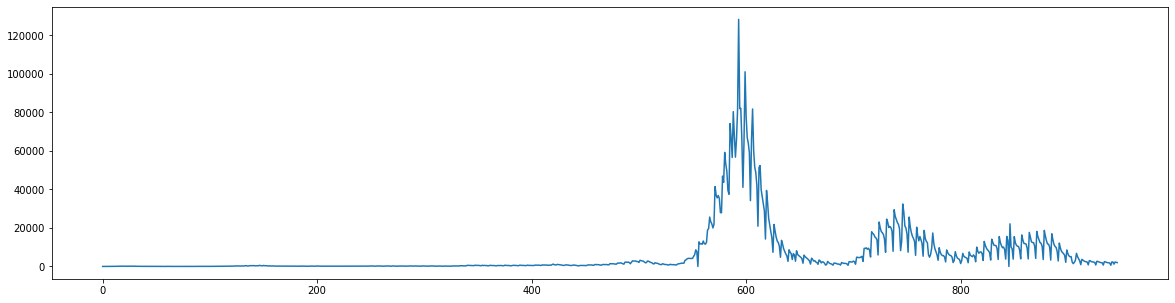

In [ ]:
rawdata = pd.read_csv("./drive/MyDrive/Colab Notebooks/캡스톤/daily_data/서울_data.csv")
rawdata.dropna(inplace=True)
rawdata.reset_index(drop=True, inplace=True)

# 데이터 확인하기
plt.figure(figsize=(20,5))
plt.plot(range(len(rawdata)), rawdata["daily_Acc"])
rawdata.head()

In [16]:
# MinMaxScaler를 사용하여 데이터를 0~1로 변환
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
rawdata["daily_Acc"] = min_max_scaler.fit_transform(rawdata["daily_Acc"].to_numpy().reshape(-1,1))

In [17]:
# train과 test 나누기
train = rawdata[:-100]
data_train = train["daily_Acc"].to_numpy()

test = rawdata[-100:]
data_test = test["daily_Acc"].to_numpy()

In [18]:
import torch
import torch.nn as nn
import numpy as np
import math

# Transformer Encoder, Decoder


*   transformer에 사용할 수 있도록 dataset 생성, torch의 nn.transformer를 사용하여 모델링을 진행.



### Sliding Window Dataset

학습을 위한 input_data, output_data 필요. <br>
<br>
<br>
시계열 예측을 위해 데이터의 일정한 길이의 input window, output window를 설정하고, 데이터의 첫 부분부터 끝 부분까지 sliding 시켜서 dataset을 생성.
<br>
<br>
<br>
input window를 모델의 input으로, output window를 모델의 output으로 사용.

#### torch의 Dataset 클래스를 사용하여 window dataset을 생성하는 클래스를 선언하였다.


*   input, output, stride을 입력받은 후 iw+ow만큼의 길이를 stride간격으로 sliding 하면서 dataset을 생성.
*   transformer의 input, decoder input, output으로 활용하기 위해 세 가지의 값을 return 하도록 만듬.
*   1. input window<br>
    2. output window,   <br>
    3. output window - 첫 번째 값



In [19]:
from torch.utils.data import DataLoader, Dataset

class windowDataset(Dataset):
    # input window, output window, stride을 입력받음.
    def __init__(self, y, input_window=80, output_window=20, stride=5):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        # input, decoder input, output return
        return self.x[i], self.y[i, :-1], self.y[i,1:]
    def __len__(self):
        return self.len

In [20]:
iw = 60 # input window size
ow = 7 # output window size

train_dataset = windowDataset(data_train, input_window=iw, output_window=ow, stride=1)
train_loader = DataLoader(train_dataset, batch_size=64)

# Modeling
<br>
input size와 output size의 크기가 imbeding size와 vocab size 였던 것이 모두 1이 됨.

In [21]:
from torch.nn import Transformer
from torch import nn
import torch
import math

class TFModel(nn.Module):
    def __init__(self,d_model, nhead, nhid, nlayers, dropout=0.5):
        super(TFModel, self).__init__()
        self.transformer = Transformer(d_model=d_model, nhead=nhead, dim_feedforward=nhid, num_encoder_layers=nlayers, num_decoder_layers=nlayers,dropout=dropout)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.pos_encoder_d = PositionalEncoding(d_model, dropout)
        self.linear = nn.Linear(d_model, 1)
        self.encoder = nn.Linear(1, d_model)
        self.encoder_d = nn.Linear(1, d_model)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, tgt, srcmask, tgtmask):
        src = self.encoder(src)
        src = self.pos_encoder(src)

        tgt = self.encoder_d(tgt)
        tgt = self.pos_encoder_d(tgt)
        output = self.transformer(src.transpose(0,1), tgt.transpose(0,1), srcmask, tgtmask)
        output = self.linear(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

def gen_attention_mask(x):
    mask = torch.eq(x, 0)
    return mask



*   data가 univariate time series이므로 input과 output의 차원이 모두 1차원.
*   input data의 1차원 벡터를 d_model의 차원으로 linear layer와 positional encoding을 거쳐 transformer를 통과할 수 있도록 만듬.
*   출력의 차원을 1차원으로 만들어서 최종 output이 나오도록 함.
*   padding mask는 생략.



In [22]:

device = torch.device("cuda")

lr = 1e-3
model = TFModel(256, 8, 256, 2, 0.1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [23]:
epoch = 2000
from tqdm import tqdm

model.train()
progress = tqdm(range(epoch))
for i in progress:
    batchloss = 0.0
    
    for (inputs, dec_inputs, outputs) in train_loader:
        optimizer.zero_grad()
        src_mask = model.generate_square_subsequent_mask(inputs.shape[1]).to(device)
        tgt_mask = model.generate_square_subsequent_mask(dec_inputs.shape[1]).to(device)

        result = model(inputs.float().to(device), dec_inputs.float().to(device), src_mask, tgt_mask)
        loss = criterion(result.permute(1,0,2), outputs.float().to(device))
        
        loss.backward()
        optimizer.step()
        batchloss += loss
    progress.set_description("{:0.5f}".format(batchloss.cpu().item() / len(train_loader)))

0.00079:   4%|███▏                                                                   | 90/2000 [00:45<15:59,  1.99it/s]


KeyboardInterrupt: 

*   다음 값을 예측하는 과정을 예측할 길이만큼 반복하면서 output을 update함.
*   원하는 길이만큼 예측을 완료하면 return.

In [24]:
def evaluate(length):
    input = torch.tensor(data_train[-200:]).reshape(1,-1,1).to(device).float().to(device)
    output = torch.tensor(data_train[-1].reshape(1,-1,1)).float().to(device)
    model.eval()
    for i in range(length):
        src_mask = model.generate_square_subsequent_mask(input.shape[1]).to(device)
        tgt_mask = model.generate_square_subsequent_mask(output.shape[1]).to(device)

        predictions = model(input, output, src_mask, tgt_mask).transpose(0,1)
        predictions = predictions[:, -1:, :]
        output = torch.cat([output, predictions.to(device)], axis=1)
    return torch.squeeze(output, axis=0).detach().cpu().numpy()[1:]

In [25]:
result = evaluate(100)
result = min_max_scaler.inverse_transform(result)
real = rawdata["daily_Acc"].to_numpy()
real = min_max_scaler.inverse_transform(real.reshape(-1,1))

In [26]:
print(real.shape, result.shape)

(947, 1) (100, 1)


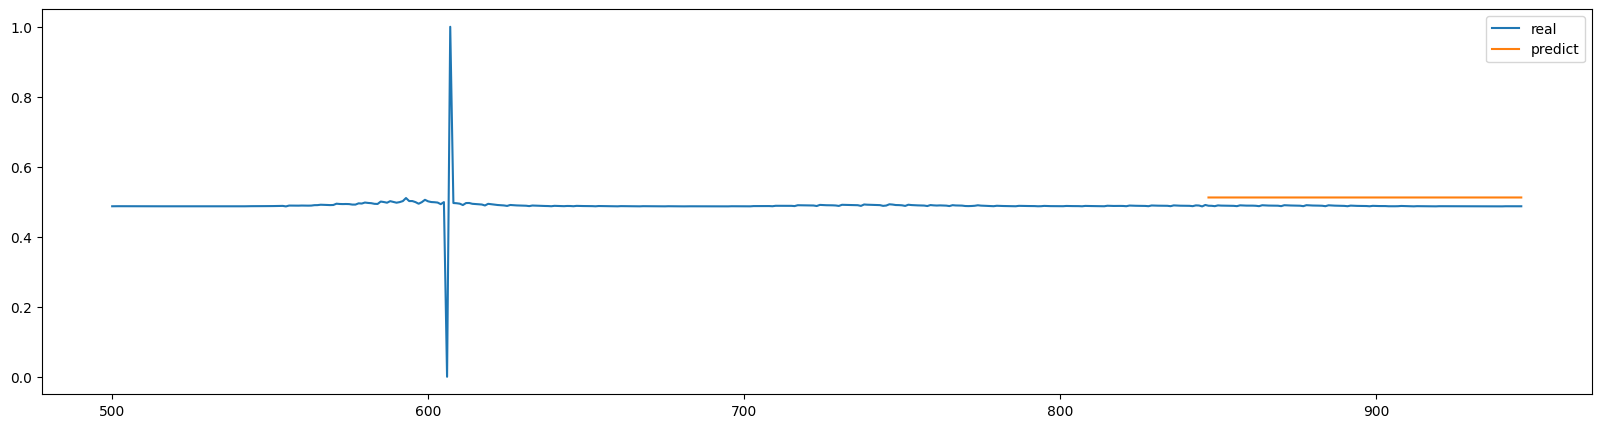

In [27]:
plt.figure(figsize=(20,5))
plt.plot(range(500,947),real[500:], label="real")
plt.plot(range(947-100,947),result, label="predict")
plt.legend()
plt.show()

input의 많은 step의 예측을 반복적으로 디코더에서 한개의 값씩 결과를 예측할 만큼 충분한 정보를 학습하지 못한 것이라 생각.

# FC Layer decoder

*  decoder에서 결과를 반복적으로 1step씩 예측하는 것이 아닌 한번에 예측하는 모델로 다시 모델링.

In [ ]:
from torch.utils.data import DataLoader, Dataset
class windowDataset(Dataset):
    def __init__(self, y, input_window=80, output_window=20, stride=5):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        # input window size의 input data, output window size의 output data.
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len

*  return 값이 input, output 두개라는 점이 다름.
------------------------------

In [ ]:
iw = 200
ow = 100

train_dataset = windowDataset(data_train, input_window=iw, output_window=ow, stride=1)
train_loader = DataLoader(train_dataset, batch_size=64)

# Modeling
transformer decoder를 사용하지 않고 transformer encoder의 output에 FC Layer를 연결해서 결과를 바로 예측한다.

In [ ]:
class TFModel(nn.Module):
    def __init__(self,iw, ow, d_model, nhead, nlayers, dropout=0.5):
        super(TFModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=nlayers) 
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        self.encoder = nn.Sequential(
            nn.Linear(1, d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, d_model)
        )
        
        self.linear =  nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, 1)
        )

        self.linear2 = nn.Sequential(
            nn.Linear(iw, (iw+ow)//2),
            nn.ReLU(),
            nn.Linear((iw+ow)//2, ow)
        ) 

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, srcmask):
        src = self.encoder(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src.transpose(0,1), srcmask).transpose(0,1)
        output = self.linear(output)[:,:,0]
        output = self.linear2(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

def gen_attention_mask(x):
    mask = torch.eq(x, 0)
    return mask

**다음과 같은 순서로 진행되도록 모델링 했다.**

1. 1차원 벡터를 d_model 차원으로 바꿔준다.
(batch, input_window, 1) => (batch, input_window, d_model)

2. transformer encoder를 통과한다.
(batch, input_window, d_model) => (batch, input_window, d_model)

3. 결과의 d_model차원을 1차원으로 바꿔준다.
(batch, input_window, d_model) => (batch, input_window, 1)

4. 1차원인 부분을 없앤다.
(batch, input_window, 1) => (batch, input_window)

5. input_window차원을 output_window차원으로 바꿔준다.
(batch, input_window) => (batch, output_window)

input window의 attention의 조합으로 output window를 바로 예측할 수 있다는 가정으로 모델을 만들었다.

linear layer들은 두 개씩 쌓아줬다.

In [ ]:
device = torch.device("cuda")
lr = 1e-4
model = TFModel(200, 100, 512, 8, 4, 0.1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
from tqdm import tqdm

epoch = 1000
model.train()
progress = tqdm(range(epoch))
for i in progress:
    batchloss = 0.0
    for (inputs, outputs) in train_loader:
        optimizer.zero_grad()
        src_mask = model.generate_square_subsequent_mask(inputs.shape[1]).to(device)
        result = model(inputs.float().to(device),  src_mask)
        loss = criterion(result, outputs[:,:,0].float().to(device))
        loss.backward()
        optimizer.step()
        batchloss += loss
    progress.set_description("loss: {:0.6f}".format(batchloss.cpu().item() / len(train_loader)))

loss: 0.001753: 100%|██████████| 1000/1000 [48:38<00:00,  2.92s/it]


In [ ]:
def evaluate():
    input = torch.tensor(data_train[-200:]).reshape(1,-1,1).to(device).float().to(device)
    model.eval()
    
    src_mask = model.generate_square_subsequent_mask(input.shape[1]).to(device)
    predictions = model(input, src_mask)
    return predictions.detach().cpu().numpy()

In [ ]:
result = evaluate()
result = min_max_scaler.inverse_transform(result)[0]
real = rawdata["daily_Acc"].to_numpy()
real = min_max_scaler.inverse_transform(real.reshape(-1,1))[:,0]

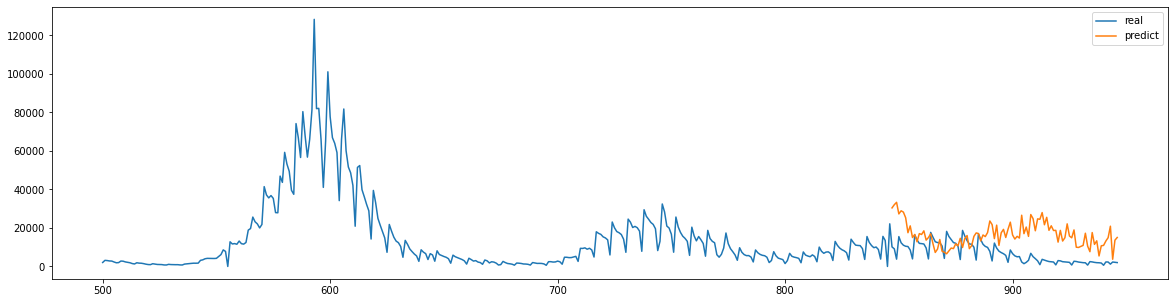

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(range(500,947),real[500:], label="real")
plt.plot(range(947-100,947),result, label="predict")
plt.legend()
plt.show()

In [ ]:
def MAPEval(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

MAPEval(result, real[-100:])

390.95102864179603

In [ ]:
torch.save(model.state_dict(), "model.pth")